In [3]:
from IPython.display import clear_output
import SALib
from SALib.sample import saltelli
from wolf_sheep.model import WolfSheep
from wolf_sheep.agents import Wolf, Sheep
from mesa.batchrunner import BatchRunner
from SALib.analyze import sobol
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from model import *
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from pprint import pprint

%matplotlib inline

In [12]:
problem = {
    'num_vars': 8,
    'names': ['international_trade', 'max_eff', 'eutax','neighbor_influence','tax_influence',
              'member_trade_multiplier','randomness','eu_strategy'],
    'bounds': [[0, 1], [0.01, 0.1], [5, 30], [0, 1], [0, 1], [0, 1], [0, 1], [0, 1]]
}

#international_trade, max_eff, eutax, neighbor_influence,
#tax_influence, member_trade_multiplier, randomness, eu_strategy):
# Set the repetitions, the amount of steps, and the amount of distinct values per variable
replicates = 2
max_steps = 1
distinct_samples = 1

'''
"other_count":"other_count",
            "average_cooperativeness":"average_cooperativeness",
            "other_wealth":"other_wealth",
            "total_wealth":"total_wealth",
            "member_wealth":"member_wealth",
            "other_eff":"other_eff",
            "total_eff":"total_eff",
            "member_eff":"member_eff"
'''
# Set the outputs
model_reporters = {"Average cooperativeness": lambda m: m.datacollector.get_model_vars_dataframe()["average_cooperativeness"].values[1:],
                   "EU count": lambda m: m.datacollector.get_model_vars_dataframe()["member_count"].values[1:],
                   "Non-EU wealth": lambda m: m.datacollector.get_model_vars_dataframe()["other_wealth"].values[1:],
                   "Total wealth": lambda m: m.datacollector.get_model_vars_dataframe()["total_wealth"].values[1:],
                   "EU wealth": lambda m: m.datacollector.get_model_vars_dataframe()["member_wealth"].values[1:],
                   "Non-EU efficiency": lambda m: m.datacollector.get_model_vars_dataframe()["other_eff"].values[1:],
                   "Total efficiency": lambda m: m.datacollector.get_model_vars_dataframe()["total_eff"].values[1:],
                   "EU-efficiency": lambda m: m.datacollector.get_model_vars_dataframe()["member_eff"].values[1:],
                  }

# We get all our samples here
param_values = saltelli.sample(problem, distinct_samples)

# READ NOTE BELOW CODE
batch = BatchRunner(RegionModel, 
                    max_steps=max_steps,
                    variable_parameters={name:[] for name in problem['names']},
                    model_reporters=model_reporters)

count = 0
data = pd.DataFrame(index=range(replicates*len(param_values)), 
                                columns=['international_trade', 'max_eff', 'eutax','neighbor_influence','tax_influence',
                                         'member_trade_multiplier','randomness','eu_strategy'])
                                    #'average_cooperativeness', 'member_count', 'other_wealth', 'total_wealth' , 'member_wealth', 
                                    #    'other_eff','total_eff' ,'member_eff' ])
data['Run'], data['average_cooperativeness'], data['member_count'], data['other_wealth'], data['total_wealth'], data['member_wealth'] , data['other_eff'], data['total_eff'], data['member_eff'] = None, None, None, None, None, None,None, None, None
#data['Run'], data['average_cooperativeness'],  data['member_count'], data['other_wealth'], data['total_wealth'], data['member_wealth'], data['other_eff'] , data['total_eff'], data['member_eff'] = None, None, None, None, None, None,None, None, None

In [13]:
# Change this for extra strategies
for i, param_val in enumerate(param_values):
    param_values[i, 7] =  0 if param_values[i, 7] < 0.5 else 1
    param_values[i, 0] =  0 if param_values[i, 0] < 0.5 else 1
for i in range(replicates):
    for j, vals in enumerate(param_values):
        vals = list(vals)
        vals[2] = int(vals[2])
        # Transform to dict with parameter names and their values
        variable_parameters = {}
        for name, val in zip(problem['names'], vals):
            variable_parameters[name] = val

        batch.run_iteration(variable_parameters, tuple(vals), count)
        iteration_data = batch.get_model_vars_dataframe().iloc[count]
        iteration_data['Run'] = count # Don't know what causes this, but iteration number is not correctly filled
        data.iloc[count, 0:8] = vals
        data.iloc[count, 8:17] = iteration_data
        count += 1
        
        clear_output()
        
        print(f'{count / (len(param_values) * (replicates)) * 100:.2f}% done')

100.00% done


In [14]:
data

,international_trade,max_eff,eutax,neighbor_influence,tax_influence,member_trade_multiplier,randomness,eu_strategy,Run,average_cooperativeness,member_count,other_wealth,total_wealth,member_wealth,other_eff,total_eff,member_eff
0,0.0,0.018701,17,0.676758,0.280273,0.907227,0.045898,1.0,0,[0.09156760190905382],[172],[1.0106430547532117],[0.009501560593713682],[0.0091949247172828],[1.010484259103654],[0.0093597415008644],[1.0105696117652914]
1,1.0,0.018701,17,0.676758,0.280273,0.907227,0.045898,1.0,1,[-0.05856656672250482],[154],[1.011069760651292],[0.00987826950888552],[0.008690855475369323],[1.0099432670901642],[0.009262298478998992],[1.010485392116457]
2,0.0,0.016240,17,0.676758,0.280273,0.907227,0.045898,1.0,2,[-0.05856656672250482],[154],[1.011069760651292],[0.00987826950888552],[0.008690855475369323],[1.0099432670901642],[0.009262298478998992],[1.010485392116457]
3,0.0,0.018701,7,0.676758,0.280273,0.907227,0.045898,1.0,3,[-0.05856656672250482],[154],[1.011069760651292],[0.00987826950888552],[0.008690855475369323],[1.0099432670901642],[0.009262298478998992],[1.010485392116457]
4,0.0,0.018701,17,0.254883,0.280273,0.907227,0.045898,1.0,4,[-0.05856656672250482],[154],[1.011069760651292],[0.00987826950888552],[0.008690855475369323],[1.0099432670901642],[0.009262298478998992],[1.010485392116457]
5,0.0,0.018701,17,0.676758,0.161133,0.907227,0.045898,1.0,5,[-0.05856656672250482],[154],[1.011069760651292],[0.00987826950888552],[0.008690855475369323],[1.0099432670901642],[0.009262298478998992],[1.010485392116457]
6,0.0,0.018701,17,0.676758,0.280273,0.383789,0.045898,1.0,6,[-0.05856656672250482],[154],[1.011069760651292],[0.00987826950888552],[0.008690855475369323],[1.0099432670901642],[0.009262298478998992],[1.010485392116457]
7,0.0,0.018701,17,0.676758,0.280273,0.907227,0.143555,1.0,7,[-0.05856656672250482],[154],[1.011069760651292],[0.00987826950888552],[0.008690855475369323],[1.0099432670901642],[0.009262298478998992],[1.010485392116457]
8,0.0,0.018701,17,0.676758,0.280273,0.907227,0.045898,0.0,8,[-0.05856656672250482],[154],[1.011069760651292],[0.00987826950888552],[0.008690855475369323],[1.0099432670901642],[0.009262298478998992],[1.010485392116457]
9,0.0,0.016240,7,0.254883,0.161133,0.383789,0.143555,0.0,9,[-0.05856656672250482],[154],[1.011069760651292],[0.00987826950888552],[0.008690855475369323],[1.0099432670901642],[0.009262298478998992],[1.010485392116457]


Parameter S1 S1_conf ST ST_conf
international_trade -0.635788 8.930608 0.878457 14.225830
max_eff -0.275799 9.461212 0.911592 14.178257
eutax -0.275799 9.461212 0.911592 14.178257
neighbor_influence -0.605866 8.973009 0.876696 14.228365
tax_influence -0.605866 8.973009 0.876696 14.228365
member_trade_multiplier -1.237285 8.154548 1.087475 13.929968
randomness -1.237285 8.154548 1.087475 13.929968
eu_strategy -0.731039 8.797846 0.889512 14.209930

Parameter_1 Parameter_2 S2 S2_conf
international_trade max_eff 0.745384 15.922550
international_trade eutax 0.745384 15.922550
international_trade neighbor_influence 1.138199 15.355505
international_trade tax_influence 1.138199 15.355505
international_trade member_trade_multiplier 1.889657 14.366350
international_trade randomness 1.889657 14.366350
international_trade eu_strategy 1.287169 15.148945
max_eff eutax 0.303813 14.777968
max_eff neighbor_influence 0.669038 14.222778
max_eff tax_influence 0.669038 14.222778
max_eff member_trade_multip

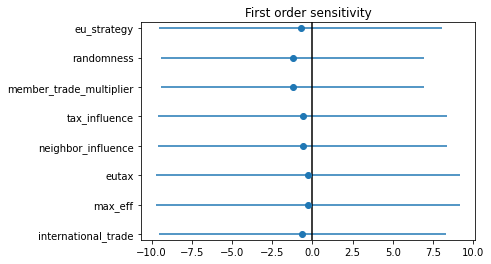

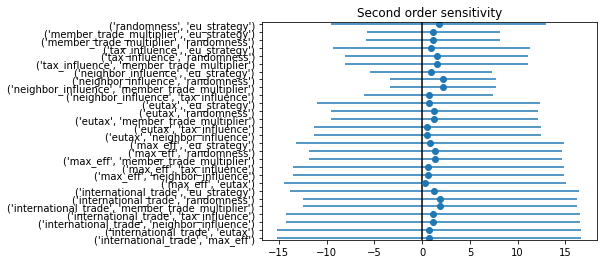

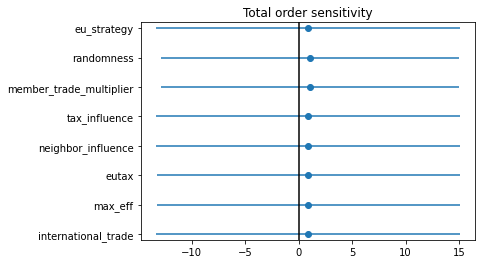

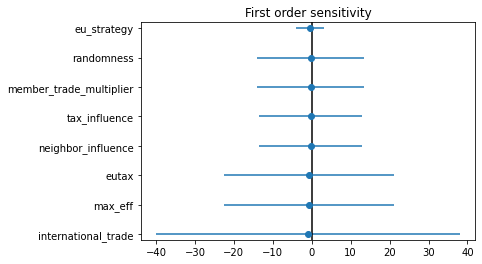

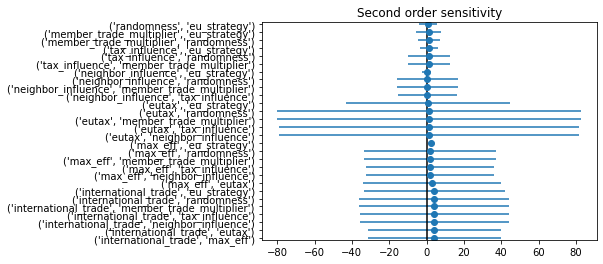

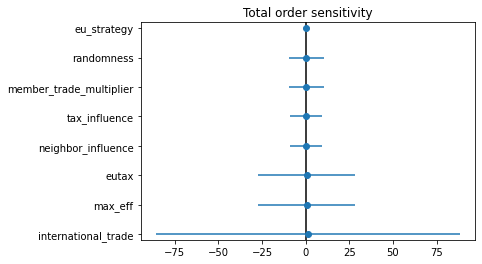

In [15]:
Si_sheep = sobol.analyze(problem, data['average_cooperativeness'].values, print_to_console=True)
Si_wolves = sobol.analyze(problem, data['other_wealth'].values, print_to_console=True)
def plot_index(s, params, i, title=''):
    """
    Creates a plot for Sobol sensitivity analysis that shows the contributions
    of each parameter to the global sensitivity.

    Args:
        s (dict): dictionary {'S#': dict, 'S#_conf': dict} of dicts that hold
            the values for a set of parameters
        params (list): the parameters taken from s
        i (str): string that indicates what order the sensitivity is.
        title (str): title for the plot
    """

    if i == '2':
        p = len(params)
        params = list(combinations(params, 2))
        indices = s['S' + i].reshape((p ** 2))
        indices = indices[~np.isnan(indices)]
        errors = s['S' + i + '_conf'].reshape((p ** 2))
        errors = errors[~np.isnan(errors)]
    else:
        indices = s['S' + i]
        errors = s['S' + i + '_conf']
        plt.figure()

    l = len(indices)

    plt.title(title)
    plt.ylim([-0.2, len(indices) - 1 + 0.2])
    plt.yticks(range(l), params)
    plt.errorbar(indices, range(l), xerr=errors, linestyle='None', marker='o')
    plt.axvline(0, c='k')

for Si in (Si_sheep, Si_wolves):
    # First order
    plot_index(Si, problem['names'], '1', 'First order sensitivity')
    plt.show()

    # Second order
    plot_index(Si, problem['names'], '2', 'Second order sensitivity')
    plt.show()

    # Total order
    plot_index(Si, problem['names'], 'T', 'Total order sensitivity')
    plt.show()